# Importing Packages

In [1]:
import numpy as np
from numpy import linalg
from scipy import linalg as splinalg
import matplotlib.pyplot as plt
from scipy import sparse as sp
import scipy.sparse.linalg
from functools import reduce
import itertools
from scipy import linalg
from scipy.linalg import expm, logm
from scipy.special import comb
from itertools import combinations_with_replacement, product
from collections import Counter
import copy
from scipy.linalg import ishermitian
import time

# Definitions

In [22]:
params = {
    'N': 10, # no. of sites
    't':1, # Hopping Amplitude
    'T': 10, # Total Time Evolution
    'tau': 0.1 # Time step
}

params['N'], params['k'] = 7, 7
params['N1'], params['N2'] = 3, 7
params['U'] = 0.001
params['mu'] = 0
params['start_site'], params['end_site'] = 0, 1

params['dim'], params['truncationParam_n'] = 0, 2
params['occupationTuple_lst'] = []
params['Map_ParticleLoc_OccupNo']={}
params['map_occupToD_Dim'] = {}

def dimension(params, **kwargs):
    '''
    For k identical bosonic particles on N lattice site, 
    Changes the dim and initializes the vac state
    based on dim.
    Makes change to the params - 'dim', 'vac' within the function.
    Make sure to define the parameters list as params.
    Return: Null
    '''
    N, k, dim = params['N'], params['k'], int(params['dim']) # N = number of sites, k = no. of identical bosonic particles
    params['dim'] = int(comb(N+k-1, k)) # This is for k identical bosonic particles
    params['vac'] = sp.csc_matrix(np.zeros(N))
    pass


In [23]:
dimension(params)
params['dim']

1716

In [24]:
def normalizeWF(psi,**kwargs):
    '''
    Return a Normalized Wavefunction
    '''
    shape, dtype = psi.shape, psi.dtype
    NWF = psi
    if np.array_equal(psi, np.zeros(shape, dtype = dtype)) == True:
        NWF = psi
    elif np.vdot(psi, psi) == 0:
        NWF = psi
    else:
        NWF = psi/(np.sqrt(np.vdot(psi, psi)))
    return NWF


# AJJ Hamiltonian

In [25]:
def creationOpMatrix(params, **kwargs):
    '''
    Returns Bosonic Creation Operator
    '''
    A = sp.diags(np.sqrt(np.arange(1, params['truncationParam_n']+1, 1)), -1)
    return A

def annihilationOpMatrix(params, **kwargs):
    '''
    Returns Bosonic Annihilation Operator
    '''
    A = sp.diags(np.sqrt(np.arange(1, params['truncationParam_n']+1, 1)), 1)
    return A

def numOpMatrix(params, site_no, **kwargs):
    '''
    Returns Bosonic Number Operator
    '''
    createOp = creationOpMatrix(params)
    nOp = createOp@createOp.transpose()
    I = sp.identity(params['truncationParam_n']+1)
    lst = [I for _ in range(params['N'])]
    if 'tilt' in kwargs:
        lst[site_no] = nOp*site_no
        matrx = sp.csc_matrix(reduce(sp.kron, lst))
        return matrx
    else: 
        lst[site_no] = nOp
        matrix1 = sp.csc_matrix(reduce(sp.kron, lst))
        lst[site_no] = nOp@nOp
        matrix2 = sp.csc_matrix(reduce(sp.kron, lst))
        return matrix1, matrix2

def HoppingOpMatrix(params, site_no, **kwargs):
    '''
    Returns Bosonic Hopping Operator
    '''
    n, N = params['truncationParam_n'], params['N']
    matrixx = sp.csc_matrix(((n+1)**N, (n+1)**N))
    if site_no != params['N']-1:
        creationOp, annihOp = creationOpMatrix(params), annihilationOpMatrix(params)
        I = sp.identity(params['truncationParam_n']+1)
        lst = [I for _ in range(params['N'])]
        lst[site_no], lst[site_no+1] = creationOp, annihOp
        matrixx = sp.csc_matrix(reduce(sp.kron, lst))
    return matrixx

In [26]:
def Prod_OccupBasis(params, **kwargs):
    '''
    Generates all combinations using product from itertools.
    Returns: valid_combinations under the k-constraint (particle
    number conservation) and all combinations.
    '''
    n, N, k = params['truncationParam_n']+1, params['N'], params['k']
    all_combinations = dict(enumerate(itertools.product(range(n), repeat=N)))
    valid_combinations = dict(filter(lambda x: sum(x[1]) == k, all_combinations.items()))
    return valid_combinations, all_combinations
# params['truncationParam_n'], params['N'], params['k'] = 2, 2, 2

def projectionMatrix(params, **kwargs):
    '''
    Creates a projection matrix whose elements are non-zero
    for the indices of the occup_states obeying k-constraint.
    '''
    valid_combinations, all_combinations = Prod_OccupBasis(params)
    rows, cols = len(valid_combinations), len(all_combinations)
    PM = sp.csc_matrix((rows, cols))
    for i, key in enumerate(list(reversed(valid_combinations.keys()))):
        PM[i, key] = 1.0
    return PM

In [27]:
def sites2_Ngk_AJJ_Hamil(params, **kwargs):
    '''
    Returns AJJ-BHM Hamiltonian Matrix and ground state
    '''
    n, N, k = params['truncationParam_n'], params['N'], params['k']
    H = sp.csc_matrix(((n+1)**N, (n+1)**N))
    PM = projectionMatrix(params)

    for i in range(params['N']):
        HopOp, nOp_mu = HoppingOpMatrix(params, i), numOpMatrix(params, i, tilt = True)
        NumOp, NumOp_2 = numOpMatrix(params, i)
        H += -params['t']*(HopOp+HopOp.transpose()) + 0.5*params['U']*(NumOp_2 - NumOp) - params['mu']*nOp_mu
        
    H = PM@H@PM.transpose()
    # return H
    eigenval, eigenvec = sp.linalg.eigsh(H, k=1, which='SA')
    return H, eigenvec

# $e^{-i\phi\hat{N}_{R_{1}}}$ Operators where $\phi = \pi$

In [28]:
def phi_Nop(params, **kwargs):
    '''
    Returns an operator of the form e^{ -i * \\phi * \\hat{N}_{R_{1}}}
    Args: params
    kwargs: phi [Required]: pass an angle.
    '''
    phi = kwargs['phi']
    diag_elements = [expm(-1j * n * phi)[0][0] for n in range(params['truncationParam_n'] + 1)]
    print(diag_elements)
    A = sp.diags(diag_elements, offsets=0)  
    return A

In [29]:
# params['truncationParam_n'] = 2
# phi_Nop(params, phi = np.pi).toarray()

In [30]:
phi_Nop(params, phi = np.pi).toarray()

[(1+0j), (-1-1.2246467991473532e-16j), (1+2.4492935982947064e-16j)]


array([[ 1.+0.0000000e+00j,  0.+0.0000000e+00j,  0.+0.0000000e+00j],
       [ 0.+0.0000000e+00j, -1.-1.2246468e-16j,  0.+0.0000000e+00j],
       [ 0.+0.0000000e+00j,  0.+0.0000000e+00j,  1.+2.4492936e-16j]])

In [31]:
def prdt_ephiN_op(params, **kwargs):
    '''
    Returns an operator of the form e^{ -i * \\phi * \\hat{N}_{R_{1}}} for a region in AJJ
    Args: params,
    kwargs: phi
    Note:
    params['start_site']: where the region is starting
    params['end_site']: where the region is ending
    for eg, if region-1 is from 0 till 29,
    then (start_site, end_site) = (0, 30).
    '''
    phi = kwargs['phi']
    A = phi_Nop(params, phi = phi)
    start_site, end_site = params['start_site'], params['end_site'] 
    createOp = creationOpMatrix(params)
    I = sp.identity(createOp.shape[0])
    lst = [I for _ in range(params['N'])]
    for i in range(start_site, end_site, 1):
        lst[i] = A
    matrixx = reduce(sp.kron, lst)
    return matrixx

In [32]:
prdt_ephiN_op(params, phi = np.pi).toarray().shape

[(1+0j), (-1-1.2246467991473532e-16j), (1+2.4492935982947064e-16j)]


(2187, 2187)

# <font>Applying $\ket{\psi^{\prime}} = e^{ -i \phi \hat{N}_{R_{1}}}\ket{\psi}$</font>

In [33]:
def generate_psiPrime(params, **kwargs):
    '''
    Returns wavefunction when Parity Operator for a region is applied on WFn.
    kwargs: start_site, end_site, eigenvec [Required].
    eigenvec: Ground state of AJJ.
    For \\phi != \\pi - pass optional argument phi to apply phase-changing operator with a phase of \\phi other than \\pi.
    '''
    PM = projectionMatrix(params)
    if 'phi' in kwargs:
        matrixx = PM@prdt_ephiN_op(params, phi = kwargs['phi'])@PM.transpose()
    else:
        matrixx = PM@prdt_parity_op(params)@PM.transpose()
    wfn = matrixx@kwargs['eigenvec']
    return wfn

In [34]:
H, eigenvec = sites2_Ngk_AJJ_Hamil(params)
# H = sites2_Ngk_AJJ_Hamil(params)

D:\AnacondaFinal\anacondaInstall\envs\AJJ\Lib\site-packages\scipy\sparse\_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


In [35]:
H.shape

(393, 393)

In [36]:
psi_prime = generate_psiPrime(params, eigenvec = eigenvec, phi = np.pi/4)

[(1+0j), (0.7071067811865476-0.7071067811865476j), (6.123233995736766e-17-1j)]


In [37]:
psi_prime.shape

(393, 1)

In [38]:
for i, j in zip(eigenvec, psi_prime):
    print(i, j)

[-0.00023582] [-1.44397851e-20+0.00023582j]
[-0.00062084] [-3.8015344e-20+0.00062084j]
[-0.00084762] [-5.19015354e-20+0.00084762j]
[-0.00062388] [-3.82015676e-20+0.00062388j]
[-0.00087288] [-5.3448479e-20+0.00087288j]
[-0.00363952] [-2.22856372e-19+0.00363952j]
[-0.00513476] [-3.14413301e-19+0.00513476j]
[-0.00382785] [-2.34388333e-19+0.00382785j]
[-0.00468188] [-2.86682765e-19+0.00468188j]
[-0.00896957] [-5.49227735e-19+0.00896957j]
[-0.00667869] [-4.08951587e-19+0.00667869j]
[-0.0074879] [-4.58501394e-19+0.0074879j]
[-0.00754049] [-4.61721945e-19+0.00754049j]
[-0.00367288] [-2.24898742e-19+0.00367288j]
[-0.00474106] [-2.90306047e-19+0.00474106j]
[-0.00741179] [-4.53841076e-19+0.00741179j]
[-0.00567637] [-3.47577469e-19+0.00567637j]
[-0.00744604] [-4.55938288e-19+0.00744604j]
[-0.01711179] [-1.0477952e-18+0.01711179j]
[-0.01339031] [-8.19920124e-19+0.01339031j]
[-0.01438294] [-8.8070095e-19+0.01438294j]
[-0.0149683] [-9.16544016e-19+0.0149683j]
[-0.00738196] [-4.52014642e-19+0.0073819

In [39]:
np.array_equal(psi_prime, eigenvec)

False

# <font>Time Evolution of $\ket{\psi^{\prime}}$:: $\ket{\psi(t)} = e^{-i\cdot t \cdot H_{AJJ}}\ket{\psi^{\prime}}$</font>

In [40]:
def time_evolutionPsiPrime(params, **kwargs):
    '''
    Returns a list of time evolved wavefunctions obtained after the application of Parity Operator of a region 
    for time 0 to T with time step 'tau'.
    This is done wrt the AJJ Hamiltonian.
    kwargs: start_site, end_site, eigenvec, H [Required].
    H: Hamiltonian of AJJ.
    eigenvec: Ground state of AJJ.
    For \\phi != \\pi - pass optional argument phi to apply phase-changing operator with a phase of \\phi other than \\pi.
    '''
    H, eigenvec = kwargs['H'], kwargs['eigenvec']
    if 'phi' in kwargs:
        wfn = generate_psiPrime(params, eigenvec = eigenvec, phi = kwargs['phi'])
    else:
        wfn = generate_psiPrime(params, eigenvec = eigenvec)
    time_list = np.arange(0, params['T'], params['tau'])
    unitary_timeOp = [expm(-1j*t*(H.toarray())) for t in time_list]
    psi_t = [normalizeWF(uOp@wfn) for uOp in unitary_timeOp]
    return psi_t

In [41]:
start_time = time.time()


psi_t = time_evolutionPsiPrime(params, H = H, eigenvec = eigenvec, phi = np.pi)


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

[(1+0j), (-1-1.2246467991473532e-16j), (1+2.4492935982947064e-16j)]
Elapsed time: 111.80517768859863 seconds


In [42]:
psi_t

[array([[-0.00023582-5.77591405e-20j],
        [-0.00062084-1.52061376e-19j],
        [-0.00084762-2.07606141e-19j],
        [-0.00062388-1.52806270e-19j],
        [-0.00087288-2.13793916e-19j],
        [-0.00363952-8.91425488e-19j],
        [-0.00513476-1.25765320e-18j],
        [-0.00382785-9.37553332e-19j],
        [-0.00468188-1.14673106e-18j],
        [-0.00896957-2.19691094e-18j],
        [-0.00667869-1.63580635e-18j],
        [-0.0074879 -1.83400558e-18j],
        [-0.00754049-1.84688778e-18j],
        [-0.00367288-8.99594969e-19j],
        [-0.00474106-1.16122419e-18j],
        [-0.00741179-1.81536430e-18j],
        [-0.00567637-1.39030987e-18j],
        [-0.00744604-1.82375315e-18j],
        [-0.01711179-4.19118081e-18j],
        [-0.01339031-3.27968050e-18j],
        [-0.01438294-3.52280380e-18j],
        [-0.0149683 -3.66617606e-18j],
        [-0.00738196-1.80805857e-18j],
        [-0.01368389-3.35158745e-18j],
        [-0.01205242-2.95199158e-18j],
        [-0.01420668-3.47

# <font>$\hat{N}_{R_{j}} = \sum_{i \in R_{j}} n_{i}$ where $j \in {1, 2, 3}$</font>

In [43]:
def N_op(params, region_number, **kwargs):
    '''
    Returns N operator = sum of n_{i} where i belongs to a region.
    Args: params,
    region_number (integer): takes 1, 2, 3 where 1, 3 correspond to SF regions in SF-MIP-SF AJJ config and 2 - MIP region.
    '''
    PM = projectionMatrix(params)
    # print(f'PM = {PM.shape}')
    createOp = creationOpMatrix(params)
    nOp = createOp@createOp.transpose()
    if region_number == 3:
        start, end = params['N2'], params['N3']
    elif region_number == 2:
        start, end =  params['N1'], params['N2']
    elif region_number == 1:
        start, end = 0, params['N1']
    I = sp.identity(createOp.shape[0])
    lst = [I for _ in range(params['N'])]
    matrixx = PM@(sp.csc_matrix((createOp.shape[0]**params['N'], createOp.shape[0]**params['N'])))@PM.transpose()
    # matrixx = sp.csc_matrix((createOp.shape[0]**params['N'], createOp.shape[0]**params['N']))
    for i in range(start, end):
        lst[i] = nOp
        matrixx += (PM@reduce(sp.kron, lst)@PM.transpose())
        # matrixx += reduce(sp.kron, lst)
        lst[i] = I

    # matrixx = PM@matrixx@PM.transpose()
    # print(f'matrixx={matrixx.shape}')
    return matrixx 

# <font>Plot of $|\bra{\psi(t)} N_{R_{1}} - N_{R_{3}}\ket{\psi(t)}|$ vs Time</font>

In [44]:
def N1_minusN2_exp(params, **kwargs):
    '''
    Returns the list of expectation values of N1@N2, N1 - N2 operators wrt the time evolved psi-prime for different final times.
    kwargs: psi_t [Optional] - if passed, function uses this else uses the one generated from functn 'time_evolutionPsiPrime'
    phi [Optional]: Pass it to create a phase difference of \\phi other than \\pi between the two sites.
    '''
    if 'psi_t' in kwargs:
        psi_t = kwargs['psi_t']
    elif 'psi_t' not in kwargs:
        if 'phi' in kwargs:
            psi_t = time_evolutionPsiPrime(params, H = H, eigenvec = eigenvec, phi = kwargs['phi'])
        else:
            psi_t = time_evolutionPsiPrime(params, H = H, eigenvec = eigenvec)

    print(f'psit.shape={psi_t[0].shape}')
    N1 = N_op(params, region_number = 1)
    print(f'N1.shape={N1.shape}')
    N2 = N_op(params, region_number = 2)
    print(f'N2.shape={N2.shape}')
    N_diff_exp = [np.vdot(psit, (N1)@psit) - np.vdot(psit, (N2)@psit) for psit in psi_t]
    N1N2_exp = [np.vdot(psit, (N1@N2)@psit) for psit in psi_t]
    # N2_exp = [np.vdot(psit, (N2)@psit) for psit in psi_t]
    return N1N2_exp, N_diff_exp  

In [46]:
N1N2_exp, _ = N1_minusN2_exp(params, phi = np.pi)

[(1+0j), (-1-1.2246467991473532e-16j), (1+2.4492935982947064e-16j)]
psit.shape=(393, 1)
N1.shape=(393, 393)
N2.shape=(393, 393)


Elapsed time: 0.03294253349304199 seconds


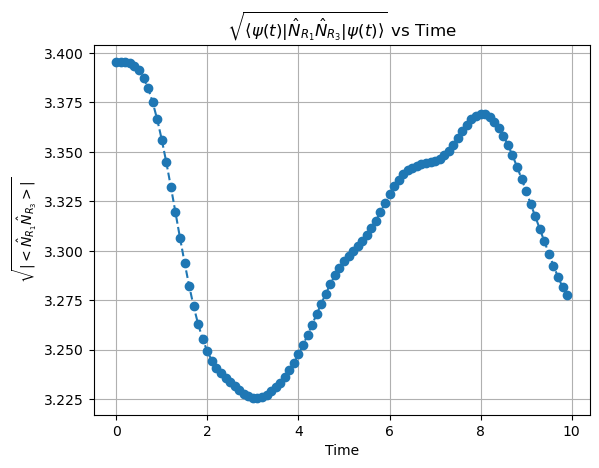

In [47]:
start_time = time.time()


# N_diff_exp = N1_minusN2_exp(params, phi = np.pi/4)
# print(f'N_diff_exp={N_diff_exp}')
t_list = np.arange(0, params['T'], params['tau']).round(1)
plt.plot(t_list, np.sqrt(np.real(N1N2_exp)), "--o")
plt.xlabel('Time')
plt.grid('True')
plt.ylabel(f'$\\sqrt{{|<\\hat{{N}}_{{R_1}}\\hat{{N}}_{{R_3}}>|}}$')
plt.title(r'$ \sqrt{ \langle \psi(t) | \hat{N}_{R_1}\hat{N}_{R_3} | \psi(t) \rangle } $ vs Time')

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

[(1+0j), (-1-1.2246467991473532e-16j), (1+2.4492935982947064e-16j)]
psit.shape=(393, 1)
N1.shape=(393, 393)
N2.shape=(393, 393)
Elapsed time: 110.46457099914551 seconds


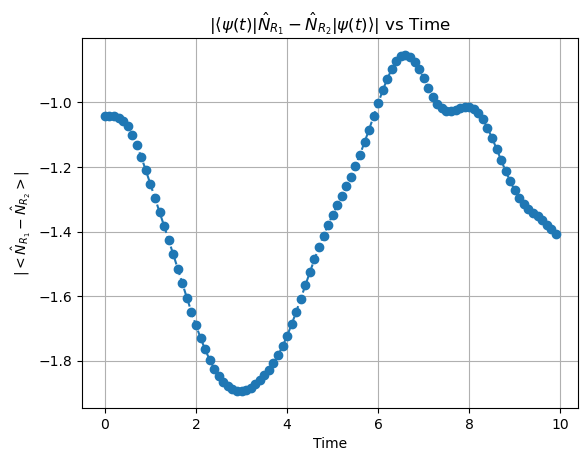

In [48]:
start_time = time.time()


_, N_diff_exp = N1_minusN2_exp(params, phi = np.pi)
# print(f'N_diff_exp={N_diff_exp}')
t_list = np.arange(0, params['T'], params['tau']).round(1)
plt.plot(t_list, np.real(N_diff_exp), "--o")
plt.xlabel('Time')
plt.grid('True')
plt.ylabel(f'$|<\\hat{{N}}_{{R_1}} - \\hat{{N}}_{{R_2}}>|$')
plt.title(r'$ | \langle \psi(t) | \hat{N}_{R_1} - \hat{N}_{R_2} | \psi(t) \rangle | $ vs Time')


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

# <font>Correlation Matrix Elements as a function of Time</font>

In [49]:
def correlations_matrix(params, **kwargs):
    '''
    Returns Correlation Matrix,
    kwargs: wfn [Required] - wavefunction which would be used to compute the Correlation matrix.
    '''
    I, annihOp = sp.identity(params['truncationParam_n']+1), annihilationOpMatrix(params)
    PM, createOp, lst = projectionMatrix(params), creationOpMatrix(params), [I for _ in range(params['N'])]
    wfn = kwargs['wfn']
    H = np.zeros((params['N'], params['N']), dtype = complex)
    for i in range(params['N']):
        for j in range(params['N']):
            if i == j:
                lst[i] = createOp@annihOp
            else:
                lst[i] = createOp
                lst[j] = annihOp
            HopOp = PM@reduce(sp.kron, lst)@PM.transpose()
            H[i, j] =  np.vdot(wfn, HopOp@wfn)
            lst[i], lst[j] = I, I
    return H

In [74]:
correl_matrix = correlations_matrix(params, wfn = psi_t[0])

In [82]:
## Use it only once to initialize it.
mag, phase = [[] for _ in correl_matrix.flatten()], [[] for _ in correl_matrix.flatten()]

In [84]:
for i in range(len(psi_t)):
    correl_matrix = correlations_matrix(params, wfn = psi_t[i])
    
    k = 0
    for i, row in enumerate(correl_matrix):
        for j, val in enumerate(row):
            magnitude, argument = np.abs(val), np.angle(val)
            mag[k].append(magnitude)
            phase[k].append(argument)
            k+=1
    
print(mag)
print(phase)

[[0.87480868506878, 0.8810962245036332, 0.899304412197902, 0.9275547503543237, 0.9629812291847926, 1.0020750688616373, 1.0410884885941272, 1.0764545401521537, 1.1051814862506713, 1.1251713235080352, 1.1354060329756344, 1.1359616557483732, 1.1278543165649062, 1.1127744697376667, 1.0927943168200591, 1.0701193017792656, 1.0469072539279614, 1.0251304910987535, 1.0064391120779634, 0.9920070547774555, 0.982387272533642, 0.9774356299891618, 0.9763603349577098, 0.9779136542101023, 0.9806862439336085, 0.9834210181842092, 0.9852544409986713, 0.9858218413280201, 0.9852153296578803, 0.9838342438815708, 0.982197296882018, 0.9807831902559759, 0.9799378726328913, 0.9798483781971743, 0.980554364202633, 0.9819618028315475, 0.9838395351945648, 0.9858073519819324, 0.9873464559394389, 0.9878649098398317, 0.9868282500486397, 0.983929043893883, 0.9792385367007632, 0.9732776083316905, 0.9669697826125072, 0.9614850064619863, 0.958025657614162, 0.9576233299180087, 0.9609992051801457, 0.9685042962179373, 0.9801

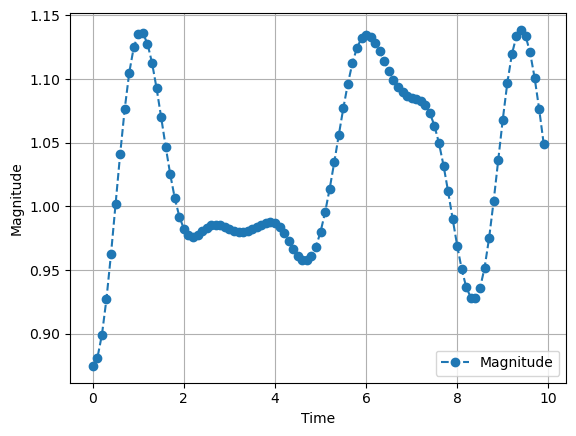

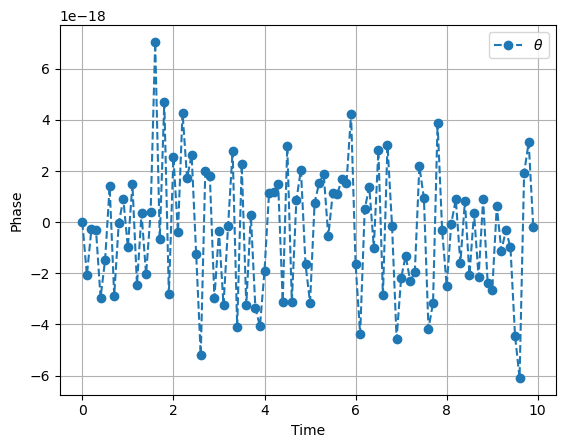

In [85]:
plt.plot(np.arange(0, params['T'], params['tau']), mag[0], "--o", label = r"Magnitude")
plt.ylabel("Magnitude")
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
plt.plot(np.arange(0, params['T'], params['tau']), phase[0], "--o", label = r"$\theta$")
plt.ylabel('Phase')
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
# len(mag[0])

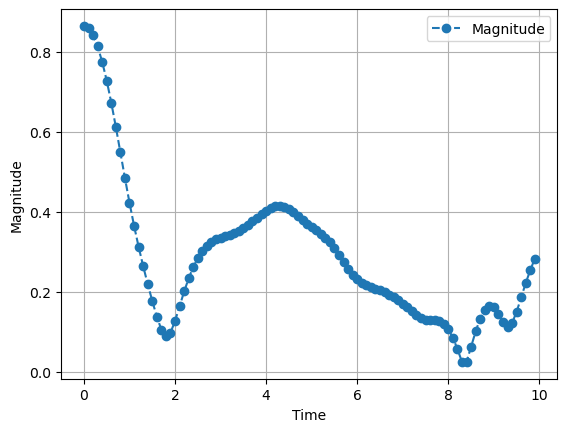

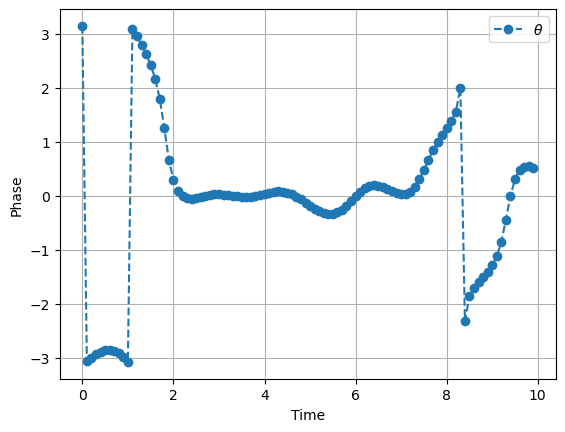

In [87]:
plt.plot(np.arange(0, params['T'], params['tau']), mag[1], "--o", label = r"Magnitude")
plt.ylabel("Magnitude")
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
plt.plot(np.arange(0, params['T'], params['tau']), phase[1], "--o", label = r"$\theta$")
plt.ylabel('Phase')
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
# len(mag[0])

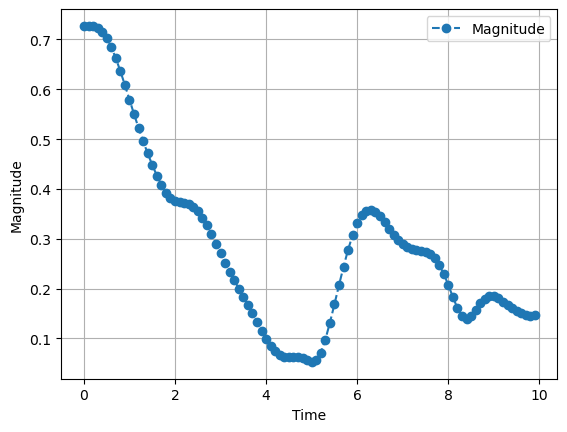

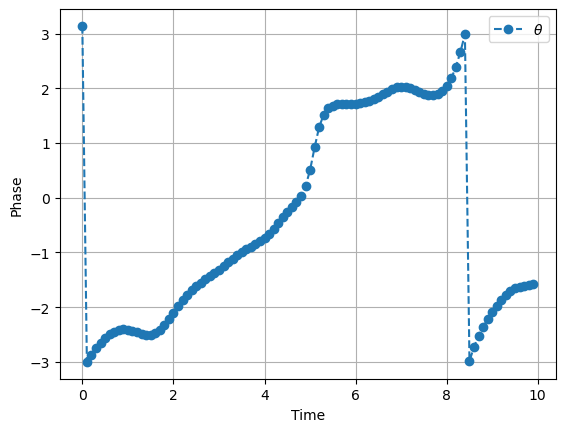

In [88]:
plt.plot(np.arange(0, params['T'], params['tau']), mag[2], "--o", label = r"Magnitude")
plt.ylabel("Magnitude")
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
plt.plot(np.arange(0, params['T'], params['tau']), phase[2], "--o" , label = r"$\theta$")
plt.ylabel('Phase')
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
# len(mag[0])

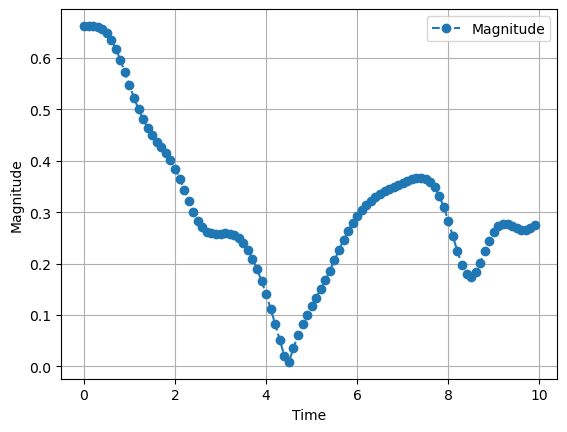

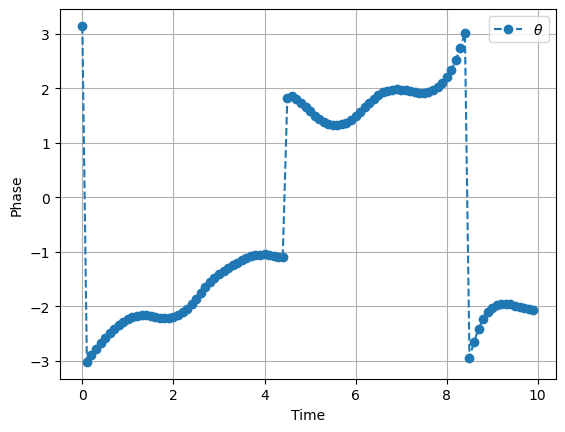

In [89]:
plt.plot(np.arange(0, params['T'], params['tau']), mag[3], "--o" , label = r"Magnitude")
plt.ylabel("Magnitude")
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
plt.plot(np.arange(0, params['T'], params['tau']), phase[3], "--o", label = r"$\theta$")
plt.ylabel('Phase')
plt.xlabel("Time")
plt.grid("True")
plt.legend()
plt.show()
# len(mag[0])

In [90]:
def correl_mag_phase(params, **kwargs):
    '''
    Returns plots of magnitude and phase of each Correlation Matrix element as a function of time.
    Args: params
    kwargs: list of psi_t [Required] - to introduce the time-dependence through wavefunction.
    '''
    fig, axs = plt.subplots(len(H.flatten()), 2, figsize=(14, 6))
    mag, phase = [], []
    for i in H:     
        mag.append(np.abs(i))
        phase.append(np.angle(i))
        im = axs[0].imshow(H, cmap='seismic', vmin=-np.abs(H).max(), vmax=np.abs(H).max())
        axs[0].set_xlabel('Site i')
        axs[0].set_ylabel('Site j')
        axs[0].set_title(f'Boson Correlation $\\langle b_i^\\dagger b_j \\rangle$')
        fig.colorbar(im, ax=axs[0])
    plt.show()
    pass

# <font>Correlation Matrix</font>

In [91]:
def correlations(params, **kwargs):
    '''
    Returns plots of Expectation Value of Hopping Ops,
    Correlation between particle at the center of lattice and
    the remaining sites.
    kwargs: wfn [Required] - wavefunction which would be used to compute the Correlation matrix.
    '''
    I, annihOp = sp.identity(params['truncationParam_n']+1), annihilationOpMatrix(params)
    PM, createOp, lst = projectionMatrix(params), creationOpMatrix(params), [I for _ in range(params['N'])]
    wfn = kwargs['wfn']
    H = np.zeros((params['N'], params['N']), dtype = complex)
    for i in range(params['N']):
        for j in range(params['N']):
            if i == j:
                lst[i] = createOp@annihOp
            else:
                lst[i] = createOp
                lst[j] = annihOp
            HopOp = PM@reduce(sp.kron, lst)@PM.transpose()
            H[i, j] =  np.vdot(wfn, HopOp@wfn)
            lst[i], lst[j] = I, I
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    H = np.power(np.abs(H), 2)
    im = axs[0].imshow(H, cmap='seismic', vmin=-np.abs(H).max(), vmax=np.abs(H).max())
    axs[0].set_xlabel('Site i')
    axs[0].set_ylabel('Site j')
    axs[0].set_title(f'Boson Correlation $\\langle b_i^\\dagger b_j \\rangle$')
    fig.colorbar(im, ax=axs[0])

    # Second subplot for the correlation plot
    middle_index = (params['N'] - 1) // 2
    correlation_rate = H[middle_index, :]
    axs[1].plot(list(range(params['N'])), correlation_rate)
    axs[1].set_xlabel('Site i')
    axs[1].set_ylabel('Correlation')
    axs[1].set_title(f'Correlation between particle at site i={middle_index} and remaining sites')
    axs[1].grid(True)
    plt.show()
    pass

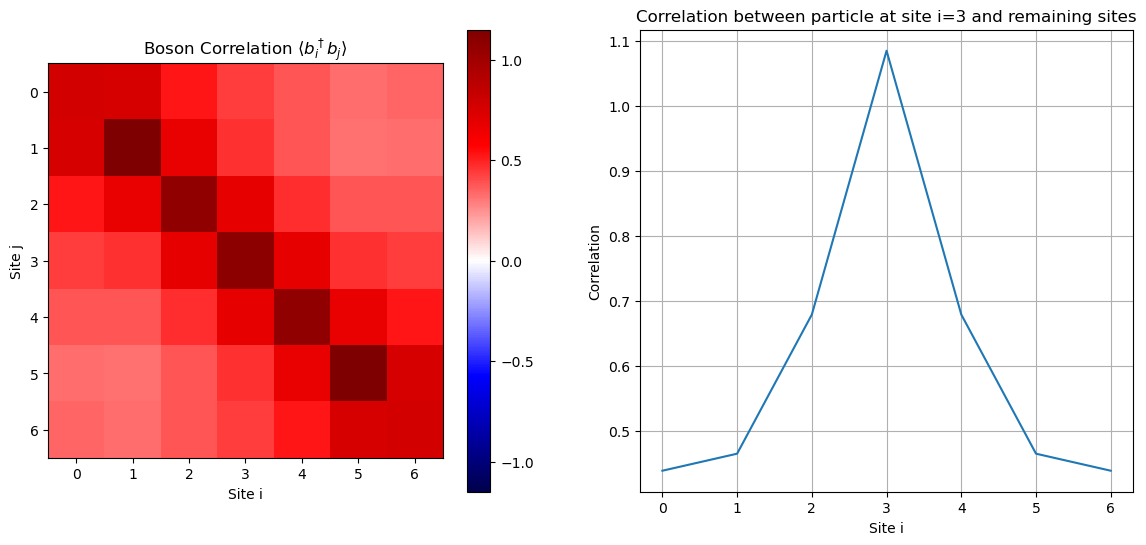

In [92]:
correlations(params, wfn = eigenvec)

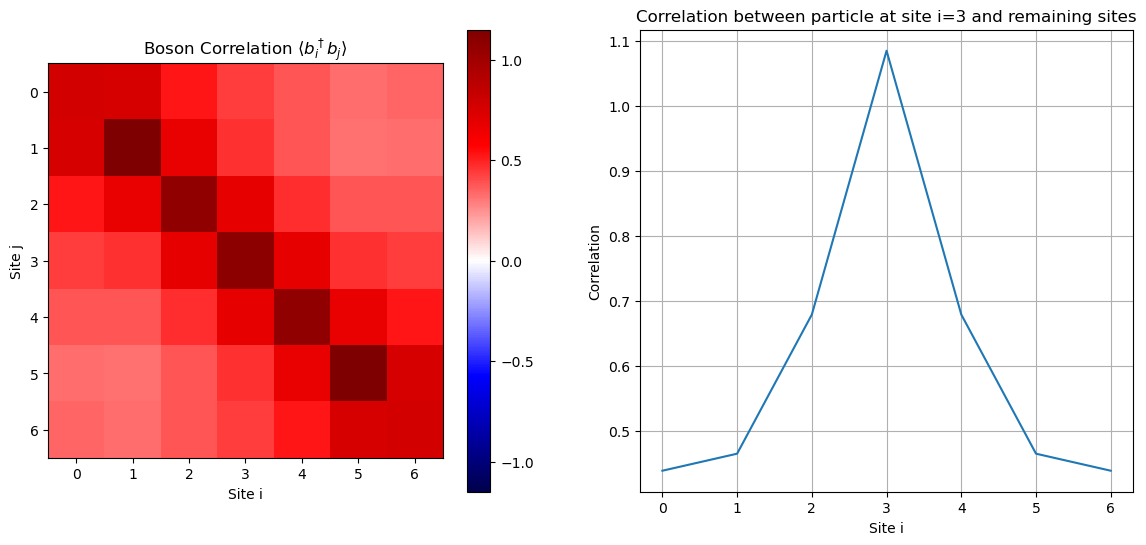

In [93]:
correlations(params, wfn = psi_t[0])

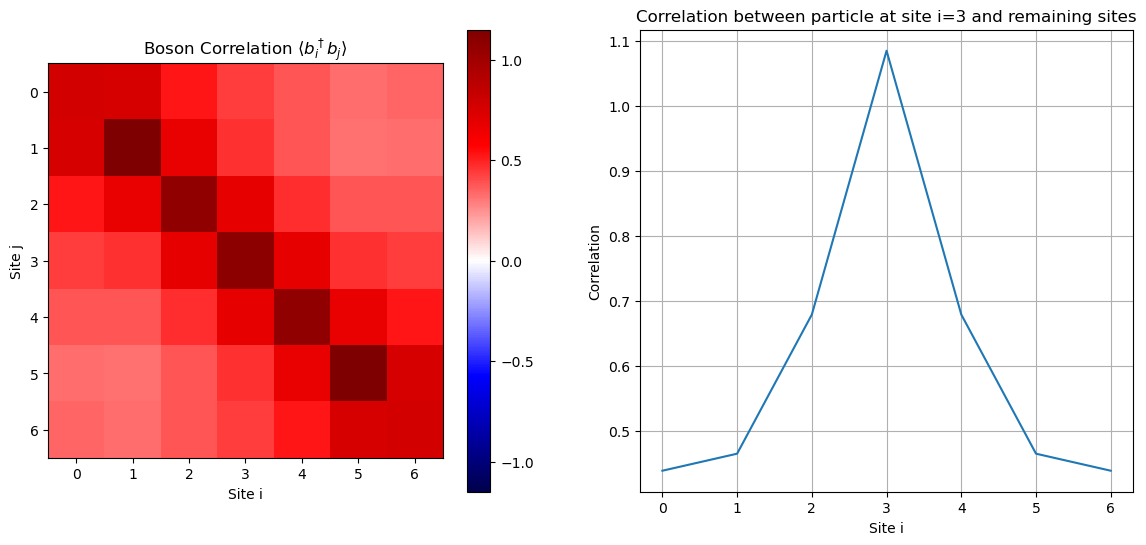

In [94]:
correlations(params, wfn = psi_prime)

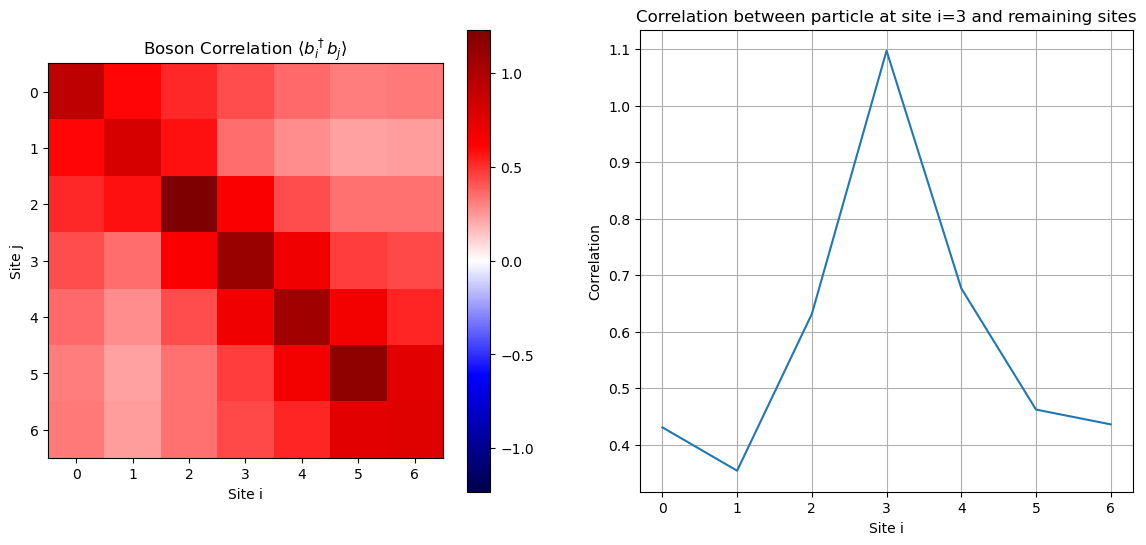

In [95]:
correlations(params, wfn = psi_t[4])

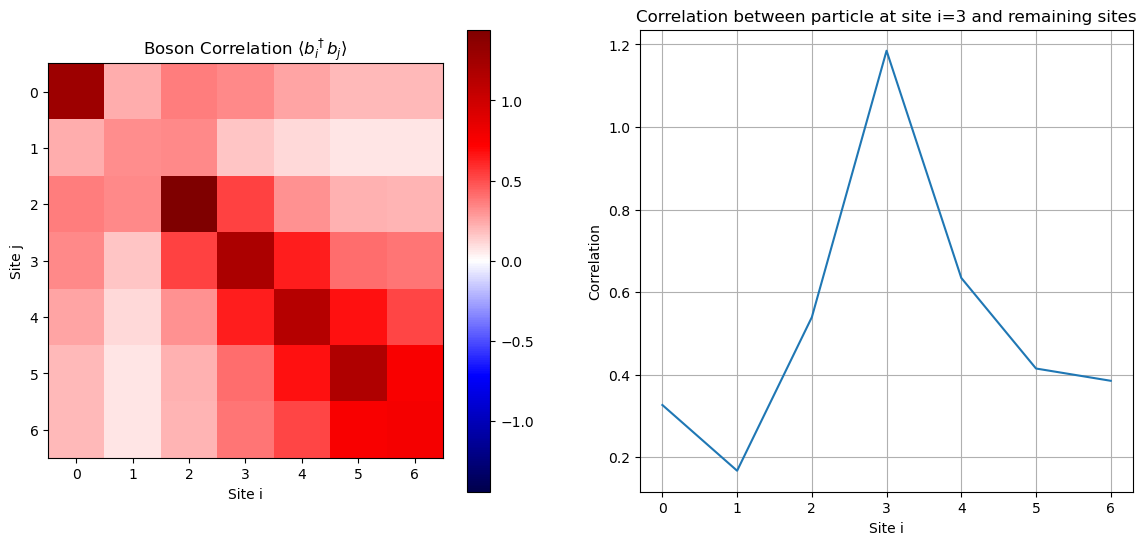

In [96]:
correlations(params, wfn = psi_t[9])

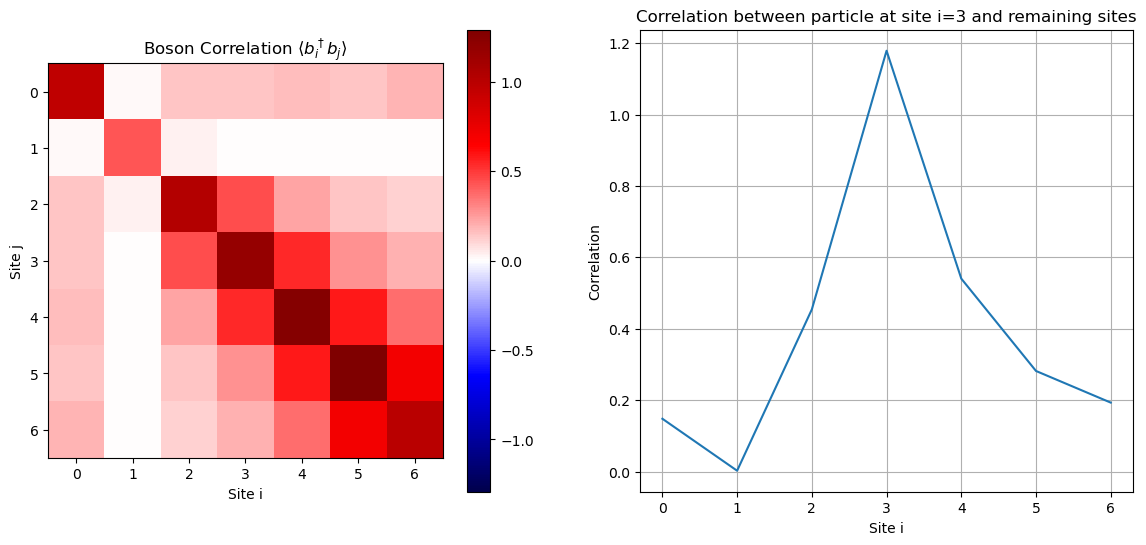

In [97]:
correlations(params, wfn = psi_t[20])

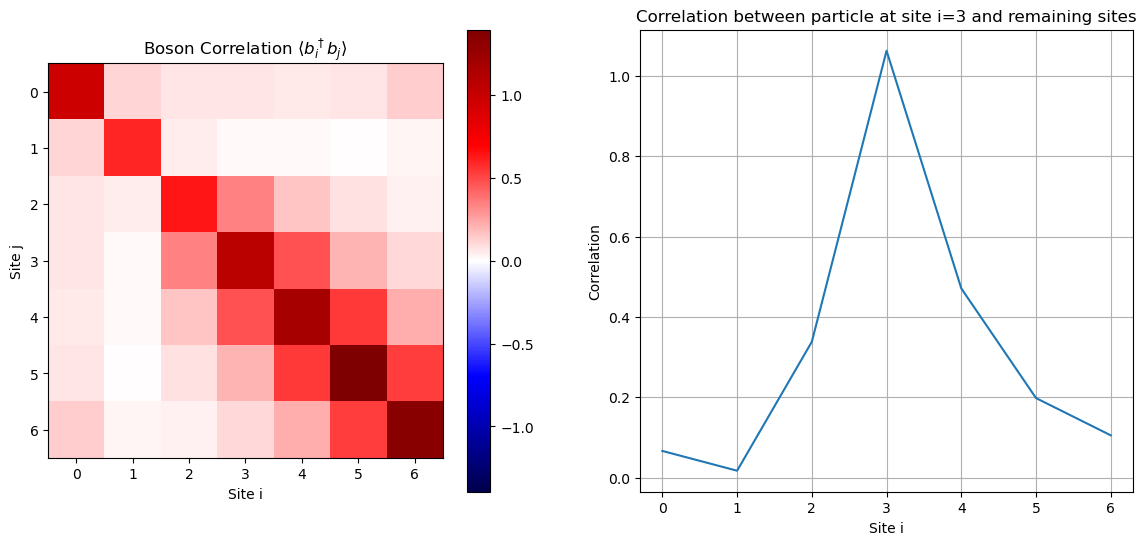

In [98]:
correlations(params, wfn = psi_t[30])

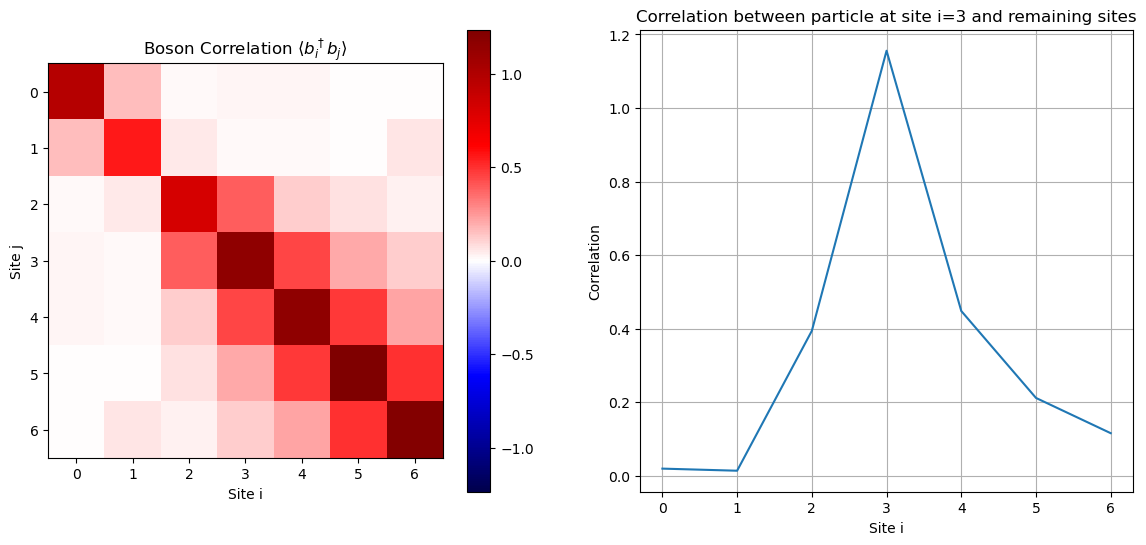

In [99]:
correlations(params, wfn = psi_t[40])

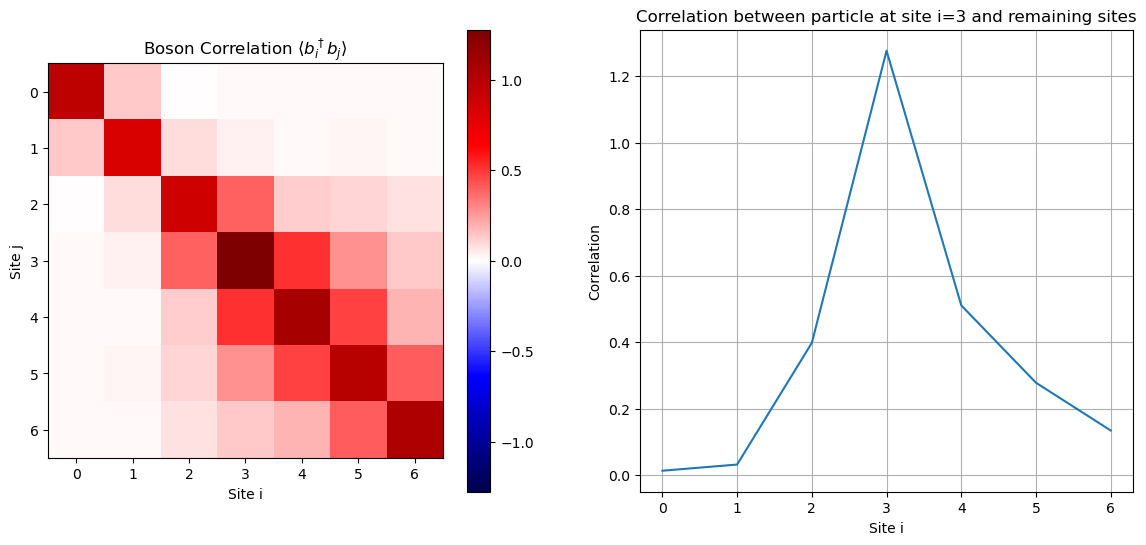

In [100]:
correlations(params, wfn = psi_t[50])

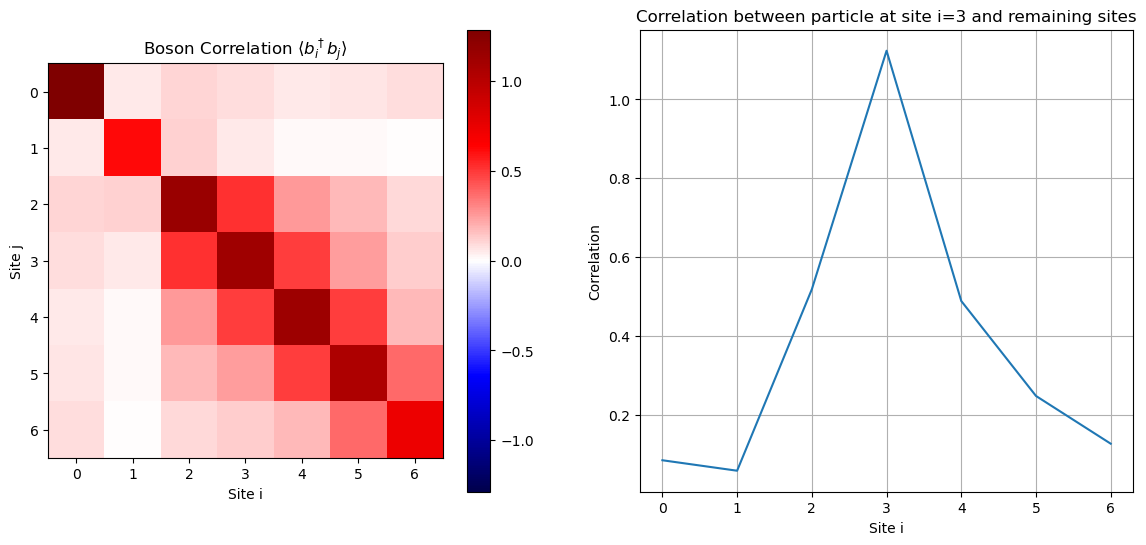

In [101]:
correlations(params, wfn = psi_t[60])

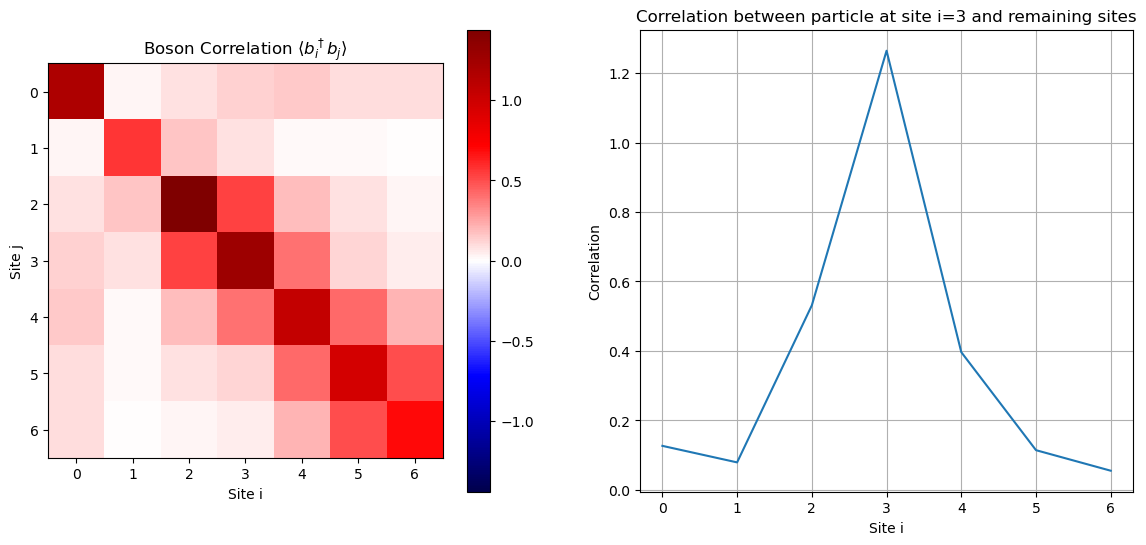

In [102]:
correlations(params, wfn = psi_t[70])

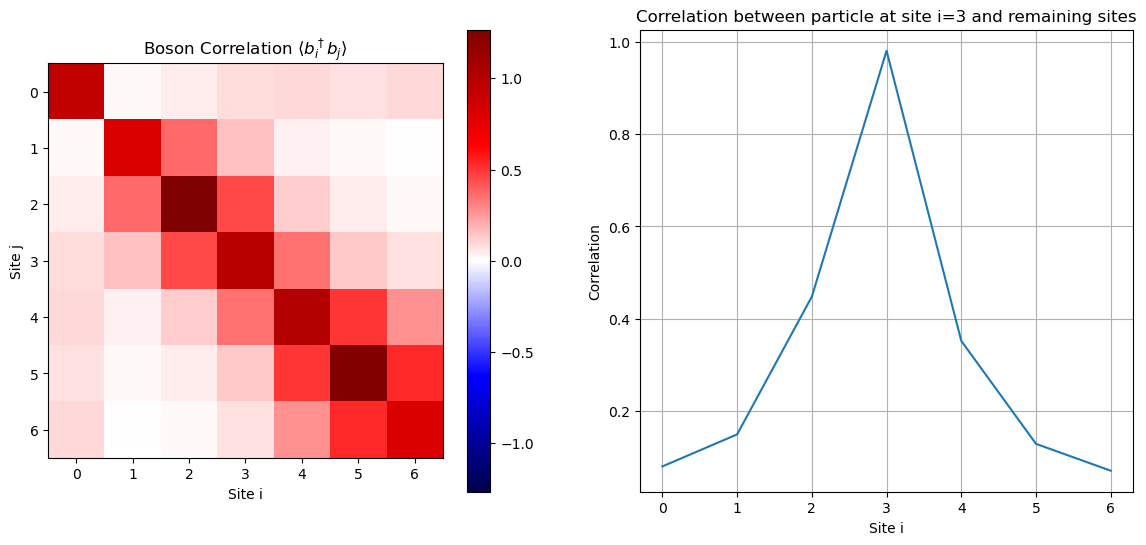

In [103]:
correlations(params, wfn = psi_t[80])

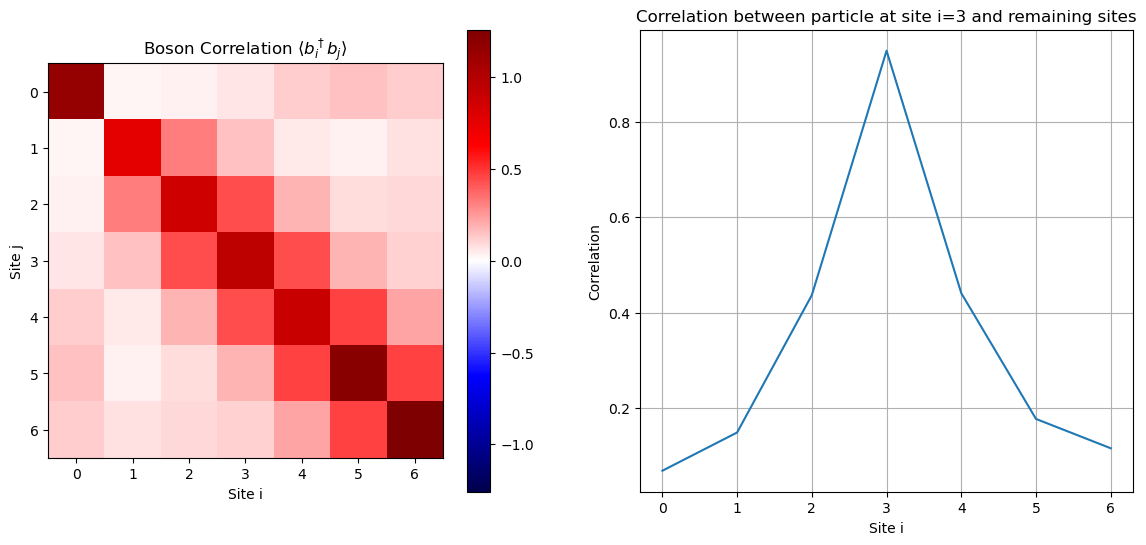

In [104]:
correlations(params, wfn = psi_t[90])

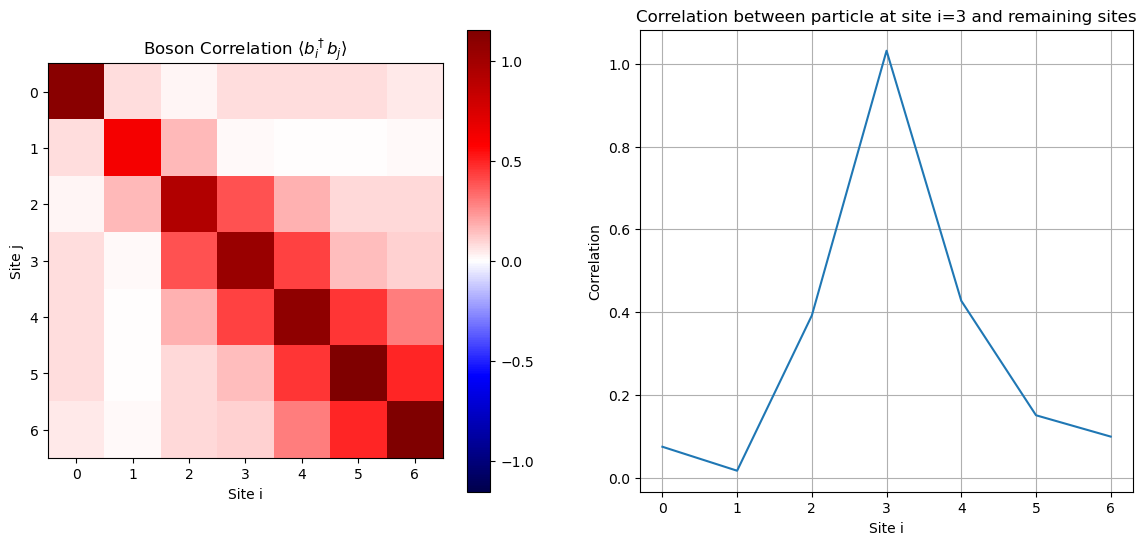

In [106]:
correlations(params, wfn = psi_t[99])

# <font>Density</font>

In [107]:
def density_eachSite(params, **kwargs):
    '''
    Returns plot of density of particles at each site.
    kwargs: wfn [Required] - wavefunction for which density at each site must be calculated.
    '''
    PM, expval_nOp = projectionMatrix(params), []
    wfn = kwargs['wfn']
    for i in range(params['N']):
        NumOp, NumOp_2 = numOpMatrix(params, i)
        nOp = PM@NumOp@PM.transpose()
        expval_nOp.append(np.vdot(wfn, nOp@wfn))
    plt.plot(list(range(params['N'])), np.real(expval_nOp), marker = "o")
    plt.ylabel('Occupation')
    plt.xlabel('Site Index')
    plt.title(f'Number of Particles at each site')
    plt.show()


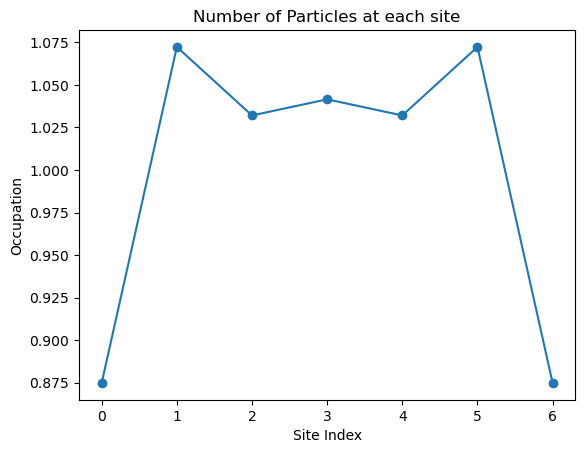

In [108]:
density_eachSite(params, wfn = eigenvec)

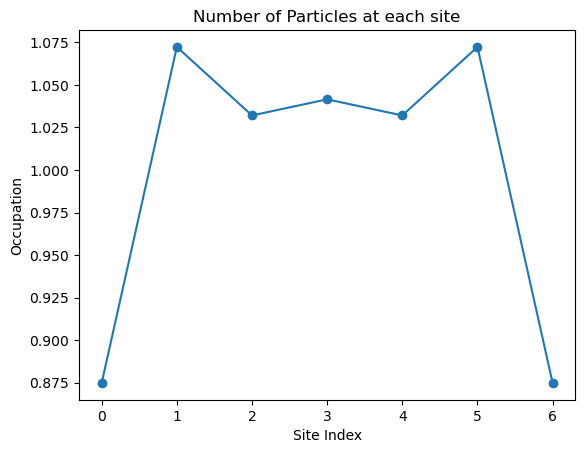

In [109]:
density_eachSite(params, wfn = psi_prime)

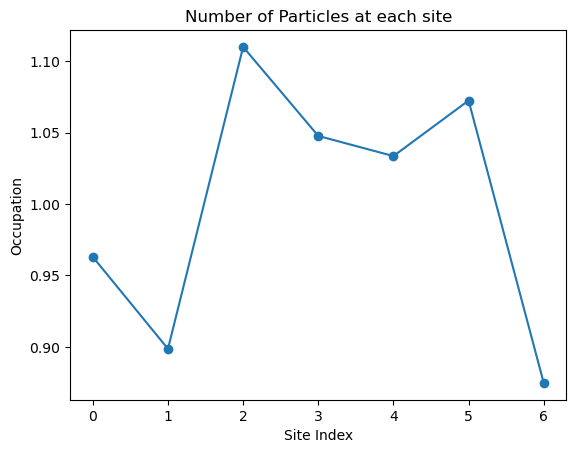

In [110]:
density_eachSite(params, wfn = psi_t[4])

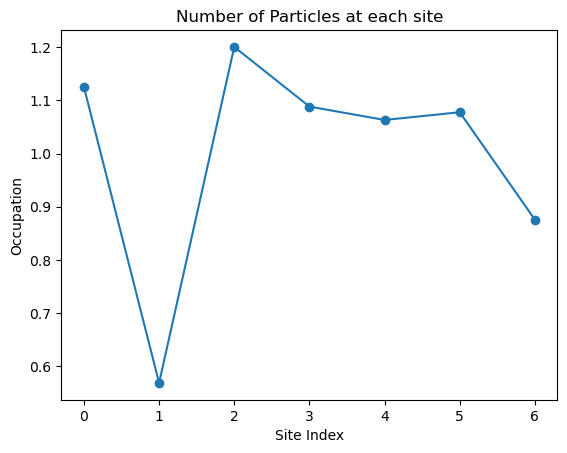

In [111]:
density_eachSite(params, wfn = psi_t[9])

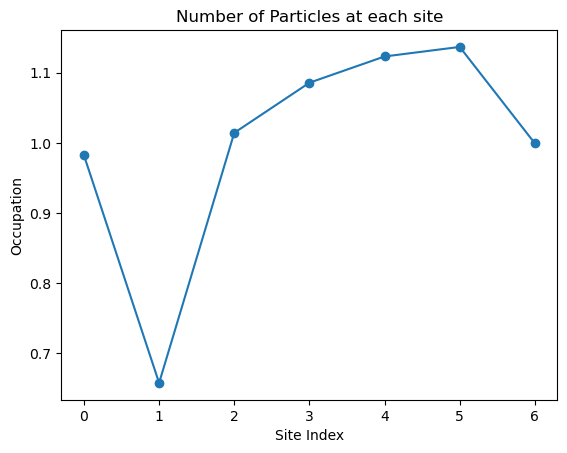

In [112]:
density_eachSite(params, wfn = psi_t[20])

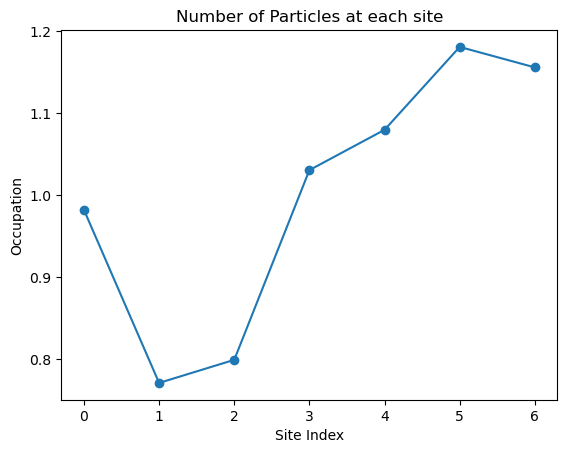

In [113]:
density_eachSite(params, wfn = psi_t[30])

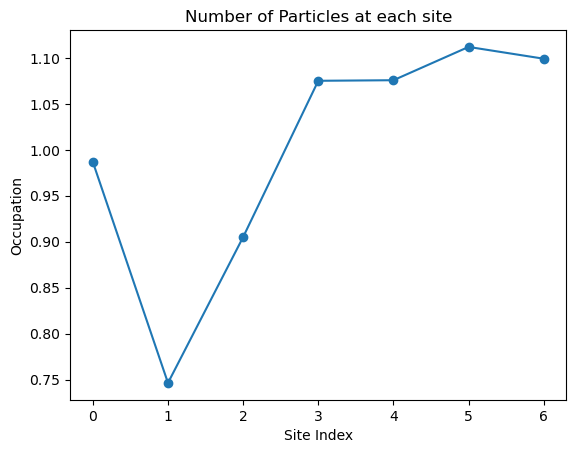

In [114]:
density_eachSite(params, wfn = psi_t[40])

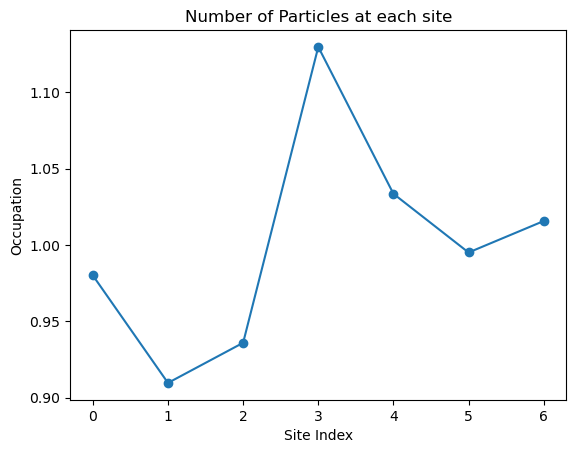

In [115]:
density_eachSite(params, wfn = psi_t[50])

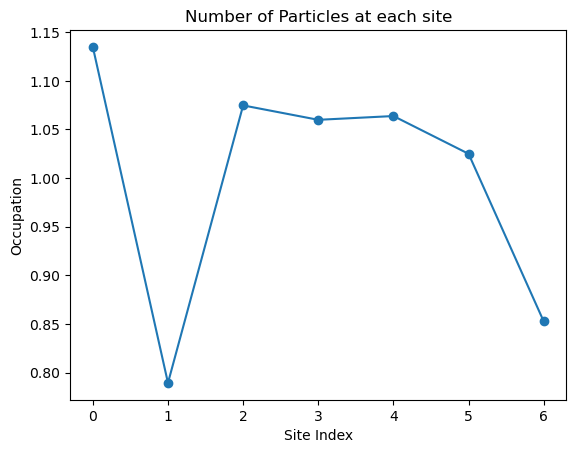

In [116]:
density_eachSite(params, wfn = psi_t[60])

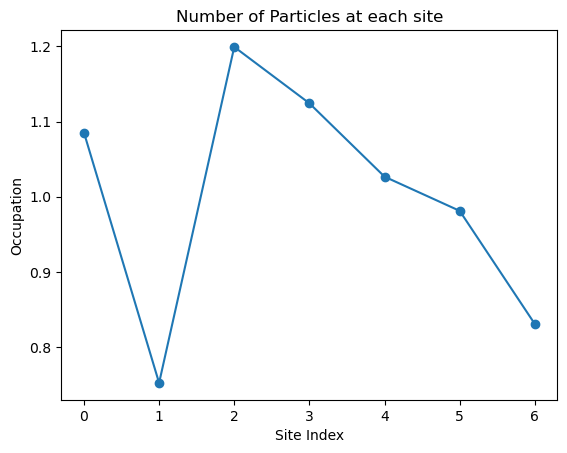

In [117]:
density_eachSite(params, wfn = psi_t[70])

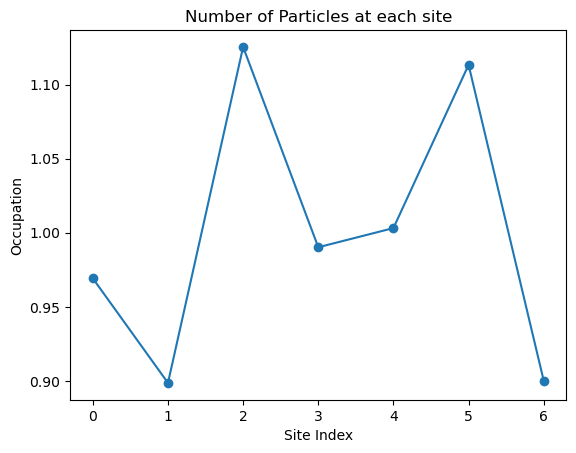

In [118]:
density_eachSite(params, wfn = psi_t[80])

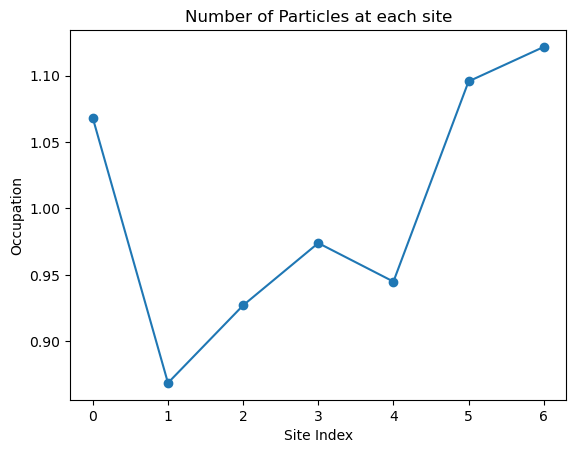

In [119]:
density_eachSite(params, wfn = psi_t[90])

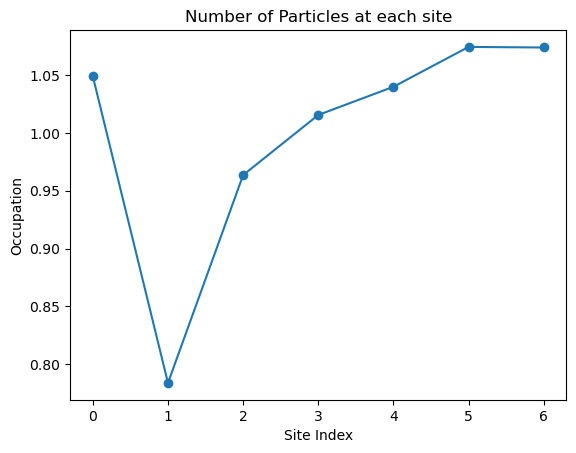

In [120]:
density_eachSite(params, wfn = psi_t[99])